In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
path="/content/drive/MyDrive/deep_learning/"
os.chdir(path)
os.listdir(path)

['model_data',
 'images',
 'results',
 'videos',
 'log',
 'impersonator_plus_plus',
 'White-box-Cartoonization',
 'YOLOX',
 'play_utils.py',
 'play_yongjiewujian.py',
 'train_reward_cls_net.ipynb',
 'video',
 'ddqn_carpole_best_ckpt.pth',
 'Double DQN.ipynb']

In [ ]:
# colab上使用env render的必须库
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

Observation space: 4
Action space: 2




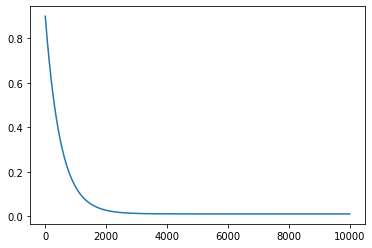

In [ ]:
import math
import random

import gym
import numpy as np
import glob
import io
import base64
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display

%matplotlib inline
_display = Display(visible=0, size=(1400, 900))
_display.start()

env = gym.make("CartPole-v0")
print("Observation space:", env.observation_space.shape[0])
print("Action space:", env.action_space.n)

epsilon_start = 0.9
epsilon_final = 0.01
epsilon_decay = 500

print('\n')
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(10000)]);

In [ ]:
import torch
import numpy as np
from torch import nn
from copy import deepcopy

class DQN:
    def __init__(self, base_net, batch_size, n_states, n_actions, device, memory_capacity=2000, epsilon=0.9, gamma=0.9, rep_frep=100, lr=0.01):
        self.eval_net = base_net
        self.target_net = deepcopy(base_net)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_states = n_states
        self.n_actions = n_actions
        self.memory_capacity = memory_capacity
        self.rep_frep = rep_frep
        self.device = device

        self.learn_step_counter = 0  # count the steps of learning process
        self.memory_counter = 0  # counter used for experience replay buffer

        # memory of columns depends on 4 elements, s, a, r, s_, the total is N_STATES*2 + 2---#
        self.memory = torch.zeros((memory_capacity, n_states * 2 + 2), device=self.device)

        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        # This function is used to make decision based upon epsilon greedy
        x = x.unsqueeze(0)  # add 1 dimension to input state x
        # input only one sample
        if np.random.uniform() < self.epsilon:  # greedy
            # use epsilon-greedy approach to take action
            actions_value = self.eval_net.forward(x)
            # torch.max() returns a tensor composed of max value along the axis=dim and corresponding index
            # what we need is the index in this function, representing the action of cart.
            action = torch.argmax(actions_value, dim=1)  # return the argmax index
        else:  # random
            action = torch.randint(0, self.n_actions, (1,), device=self.device)
        return action

    def store_transition(self, s, a, r, s_):
        # This function acts as experience replay buffer
        transition = torch.cat((s, torch.tensor([a, r], device=self.device), s_), dim=-1)  # horizontally stack these vectors
        # if the capacity is full, then use index to replace the old memory with new one
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def train_step(self):
        # Define how the whole DQN works including sampling batch of experiences,
        # when and how to update parameters of target network, and how to implement
        # backward propagation.

        # update the target network every fixed steps
        if self.learn_step_counter % self.rep_frep == 0:
            # Assign the parameters of eval_net to target_net
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        self.epsilon = epsilon_by_frame(self.learn_step_counter)

        # Determine the index of Sampled batch from buffer
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)  # randomly select some data from buffer
        # extract experiences of batch size from buffer.
        b_memory = self.memory[sample_index, :]
        # extract vectors or matrices s,a,r,s_ from batch memory and convert these to torch Variables
        # that are convenient to back propagation
        b_s = b_memory[:, :self.n_states]
        # convert long int type to tensor
        b_a = b_memory[:, self.n_states:self.n_states + 1].type(torch.int64)
        b_r = b_memory[:, self.n_states + 1:self.n_states + 2]
        b_s_ = b_memory[:, -self.n_states:]

        # calculate the Q value of state-action pair
        q_eval = self.eval_net(b_s).gather(1, b_a)  # (batch_size, 1)
        # print(q_eval)
        # calculate the q value of next state
        q_next = self.target_net(b_s_).detach()  # detach from computational graph, don't back propagate
        # select the maximum q value
        # print(q_next)
        # q_next.max(1) returns the max value along the axis=1 and its corresponding index
        q_target = b_r + self.gamma * q_next.max(dim=1)[0].view(self.batch_size, 1)  # (batch_size, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()  # reset the gradient to zero
        loss.backward()
        self.optimizer.step()  # execute back propagation for one step
        return loss.cpu().item()

In [ ]:
class QNet(nn.Module):
  def __init__(self, nums_input, nums_output):
    super(QNet, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(nums_input, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, nums_output)
    )

  def forward(self, x):
    return self.layers(x)


def weight_init(m):
    if isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, 0, 0.1)
      if m.bias is not None:
          nn.init.constant_(m.bias, 0)

In [ ]:
batch_size = 32
total_episode = 5000
loss_history = []
reward_history = []
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

net = QNet(env.observation_space.shape[0], env.action_space.n)
net.to(device)
weight_init(net)
agent = DQN(net, batch_size, env.observation_space.shape[0], env.action_space.n, device, memory_capacity=2000, epsilon=0.9, gamma=0.9, rep_frep=200, lr=0.01)

In [ ]:
from tqdm import tqdm
from IPython import display

best_reward = 0.0
best_frames = []
for i_episode in tqdm(range(total_episode)):
        s = torch.tensor(env.reset(), device=device, dtype=torch.float)
        ep_r = 0
        frames = []
        while True:
            # take action based on the current state
            if i_episode > 500:
                frames.append(env.render(mode='rgb_array'))
            a = agent.choose_action(s)
            # obtain the reward and next state and some other information
            s_, r, done, _ = env.step(a.cpu().numpy()[0])
            s_ = torch.tensor(s_, device=device, dtype=torch.float)
            r = torch.tensor(r, device=device, dtype=torch.float)

            # store the transitions of states
            agent.store_transition(s, a, r, s_)

            ep_r += r
            # if the experience repaly buffer is filled, DQN begins to learn or update
            # its parameters.
            if agent.memory_counter > agent.memory_capacity:
                loss = agent.train_step()
                loss_history.append(loss)
                if done:
                    ep_r = ep_r.cpu().item()
                    reward_history.append(ep_r)
                    if ep_r > best_reward:
                        best_reward = ep_r
                        best_frames = frames
                        torch.save(net.state_dict(), os.path.join('ddqn_carpole_best_ckpt.pth'))
            if done:
                # if game is over, then skip the while loop.
                break
            # use next state to update the current state.
            s = s_

env.close()  

100%|██████████| 5000/5000 [06:33<00:00, 12.69it/s]


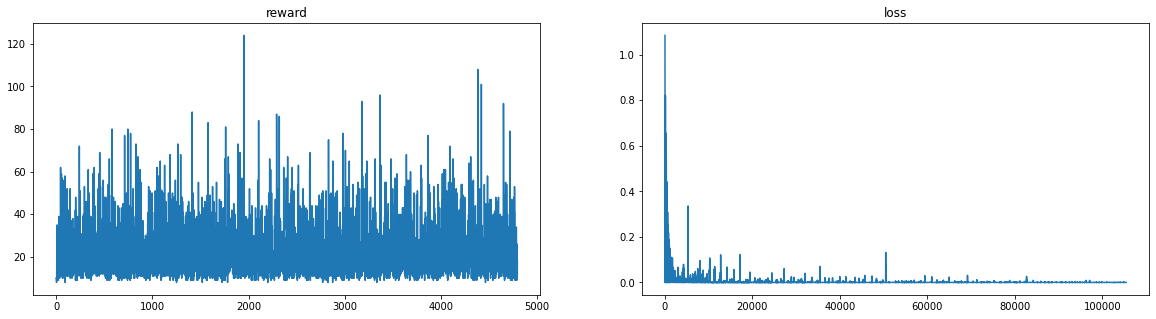

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title('reward')
plt.plot(reward_history)
plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(loss_history)
plt.show()

In [ ]:
import imageio
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize

from matplotlib import animation

def compose_gif(frames):
    imageio.mimsave("gym_CartPole.gif", frames, fps=30)


def save_frames_as_gif(frames, path=""):
    filename = 'gym_cartpole.gif'
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[0] / 72.0, frames[1].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(os.path.join(path, filename), writer='pillow', fps=60)


def Pic2Video():
    videoPath = os.path.join("best_frames")
    fps = 25
    fourcc = VideoWriter_fourcc(*'mp4v')
    videoWriter = cv2.VideoWriter(videoPath, fourcc, fps, (best_frames[0].shape[0], best_frames[0].shape[1]))

    for frame in best_frames:
      frame = cv2.cvtColor(np.asarray(frame),cv2.COLOR_RGB2BGR)
      videoWriter.write(frame)

    videoWriter.release()
    cv2.destroyAllWindows()

In [ ]:
compose_gif(best_frames)